In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from statsmodels.tsa.statespace.tools import diff
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'])

ACF and PACF plots used to determine p, q values

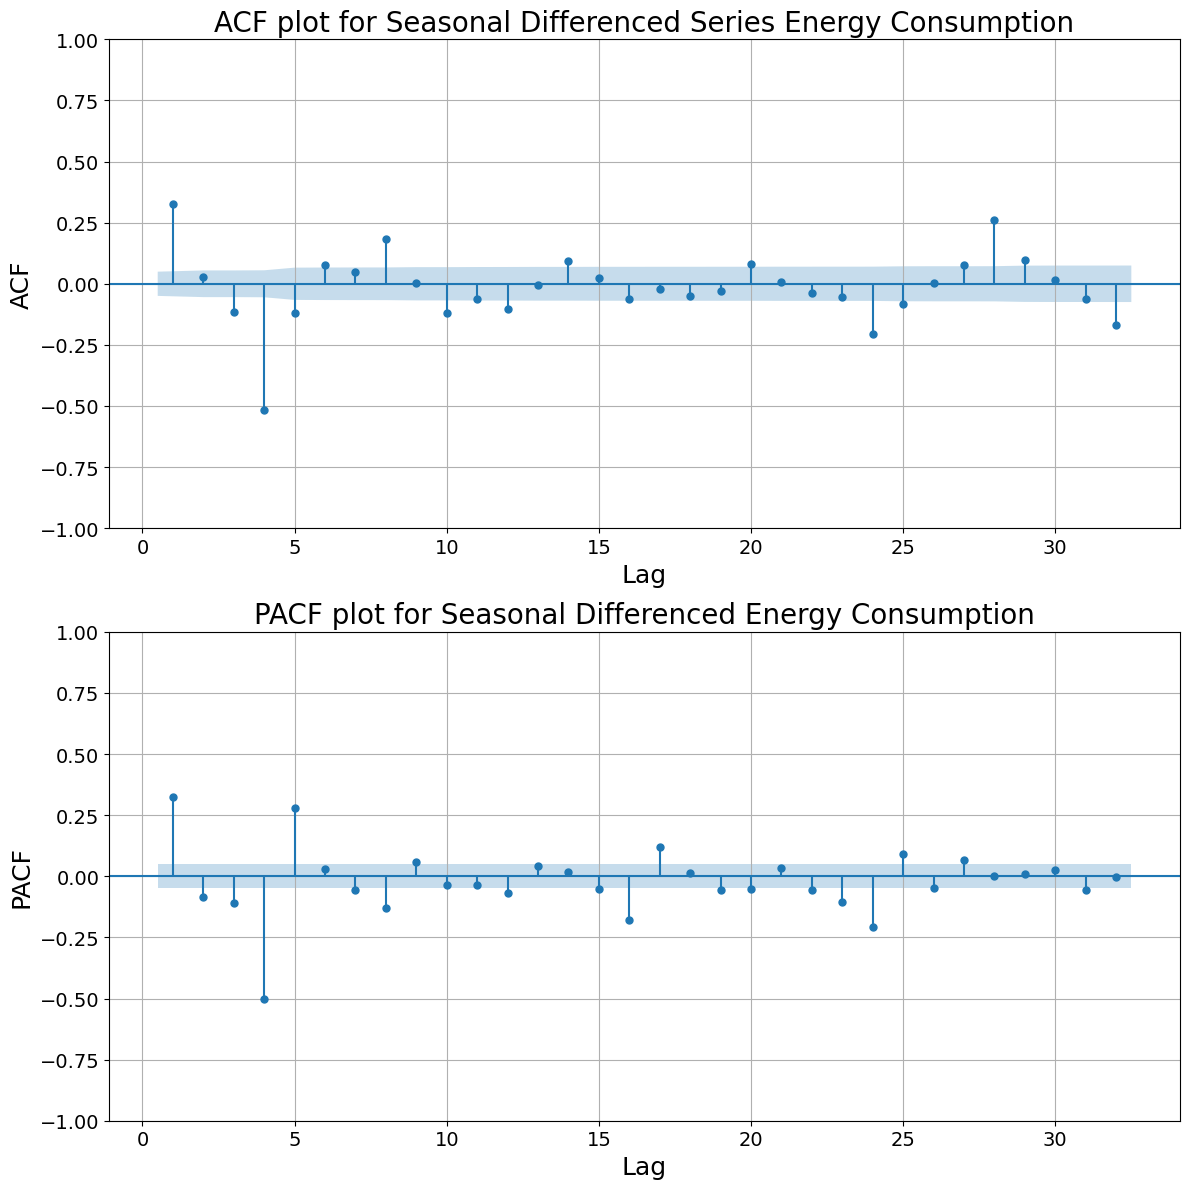

In [3]:
# how to look for orders of sarimax:
# look at lower order lags < 4 for p and q values
# p value is significant lag in lower order of PACF plot, q value is significant lag in lower order ACF plot
# seasonal P value is significant lag of seasonal lags (multiples of 4) in PACF plot, seasonal Q value is significant lag of seasonal lags in ACF plot
def plot_acf_pacf(df: pd.DataFrame) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), facecolor='w')
    
    # Plot ACF
    plot_acf(df, ax=ax1, zero=False)
    ax1.set_title("ACF plot for Seasonal Differenced Series Energy Consumption", fontsize=20)
    ax1.set_ylabel("ACF", fontsize=18)
    ax1.set_xlabel("Lag", fontsize=18)
    ax1.tick_params(axis='both', labelsize=14)
    ax1.grid(alpha=1)

    # Plot PACF
    plot_pacf(df, ax=ax2, zero=False)
    ax2.set_title("PACF plot for Seasonal Differenced Energy Consumption", fontsize=20) 
    ax2.set_ylabel("PACF", fontsize=18)
    ax2.set_xlabel("Lag", fontsize=18)
    ax2.tick_params(axis='both', labelsize=14)
    ax2.grid(alpha=1)

    plt.tight_layout()

    plt.show()

seasonal_diff = diff(df['energy_consumption'], k_diff=0, k_seasonal_diff=1, seasonal_periods=4)
plot_acf_pacf(seasonal_diff)

Data preparation

In [4]:
_ , lambda_value = boxcox(df.loc[(df['date'] <= '2023-05-14') | (df['date'] >= '2023-10-15 06:00'), 'energy_consumption'] + 0.001)
print(lambda_value)

# -1. is a reciprocal
# -.5 is a recriprocal square root
# 0.0 is a log transformation
# .5 is a square toot transform and
# 1.0 is no transform.

# custom root function lambda value 0.44
_BASE_ = 1.05
def custom_root(x, base):
    return x ** (1 / base)
def reverse_custom_root(y, base):
    return y ** base

0.4440850289511884


In [5]:
missing_date_start = '2023-05-13'
missing_date_end = '2023-10-15 06:00'

In [6]:
# adjust data
df.loc[(df['date'] > missing_date_start) & (df['date'] < missing_date_end), 'energy_consumption'] = np.nan
df['energy_consumption'] = df['energy_consumption'].apply(lambda x: x - 3 if x > 12 else x)
df['energy_consumption'] = custom_root(df['energy_consumption'], _BASE_)

# add holiday and workday effects
holiday_start = "2023-12-22"
holiday_end = "2023-12-29"
df['occupancy'] = np.where((df['date'].dt.weekday < 5) & ~((df['date'] >= holiday_start) & (df['date'] <= holiday_end)),1,0)

# create train test split
df.set_index('date', inplace=True)
train, test = train_test_split(df, test_size=0.1, shuffle=False)

Gridsearch

In [9]:
# explanatory variables
exogs = ['temperature','humidity','evaporation','wind_speed','occupancy']

In [ ]:
# caution, running may take a while, run only once if needed
orders = [(p, 0, q) for p in range(0, 3) for q in range(0, 3)]
seasonals = [(P, 1, Q, 4) for P in range(1, 3) for Q in range(2, 3)]
result_GS2 = []
for order in orders:
    for seasonal in seasonals:

        model = SARIMAX(train['energy_consumption'], exog=train[exogs], order=order, seasonal_order=seasonal)
        results = model.fit(disp=False, method='powell')

        result_GS2.append({
            'order': order,
            'seasonal_order': seasonal,
            'AIC': results.aic,
        })

results_df = pd.DataFrame(result_GS2)

In [77]:
print(results_df.sort_values(by='AIC', ascending=True))

        order seasonal_order          AIC
13  (2, 0, 0)   (2, 1, 2, 4)  3006.843249
3   (0, 0, 1)   (2, 1, 2, 4)  3007.019301
5   (0, 0, 2)   (2, 1, 2, 4)  3008.275332
15  (2, 0, 1)   (2, 1, 2, 4)  3008.819354
9   (1, 0, 1)   (2, 1, 2, 4)  3008.865652
11  (1, 0, 2)   (2, 1, 2, 4)  3009.788641
12  (2, 0, 0)   (1, 1, 2, 4)  3010.072217
2   (0, 0, 1)   (1, 1, 2, 4)  3010.638799
7   (1, 0, 0)   (2, 1, 2, 4)  3010.668541
17  (2, 0, 2)   (2, 1, 2, 4)  3010.892876
4   (0, 0, 2)   (1, 1, 2, 4)  3011.967418
14  (2, 0, 1)   (1, 1, 2, 4)  3011.989386
8   (1, 0, 1)   (1, 1, 2, 4)  3012.243878
10  (1, 0, 2)   (1, 1, 2, 4)  3013.302890
16  (2, 0, 2)   (1, 1, 2, 4)  3013.726515
6   (1, 0, 0)   (1, 1, 2, 4)  3014.905927
1   (0, 0, 0)   (2, 1, 2, 4)  3035.018771
0   (0, 0, 0)   (1, 1, 2, 4)  3050.926016


Model SARIMAX

In [11]:
# best orders from grid search with lowest AIC: (2, 0, 0)   (2, 1, 2, 4)
# train model
model = SARIMAX(train['energy_consumption'], order=(2,0,0), seasonal_order=(2,1,2,4), exog=train[exogs])
model_fit = model.fit(disp=False, method='powell')
print(model_fit.summary())

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 6h will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 6h will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                     energy_consumption   No. Observations:                 1410
Model:             SARIMAX(2, 0, 0)x(2, 1, [1, 2], 4)   Log Likelihood               -1491.422
Date:                                Sun, 06 Apr 2025   AIC                           3006.843
Time:                                        21:46:50   BIC                           3069.825
Sample:                                    03-21-2023   HQIC                          3030.382
                                         - 03-07-2024                                         
Covariance Type:                                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -0.4663      0.022    -21.639      0.000      -0.509      -0.424


In [ ]:
# get forecast and values
forecast = model_fit.get_forecast(steps=len(test), exog=test[exogs])
forecast_values = reverse_custom_root(forecast.predicted_mean.clip(lower=0),_BASE_)
forecast_ci = reverse_custom_root(forecast.conf_int().clip(lower=0),_BASE_)
test_data = reverse_custom_root(test['energy_consumption'],_BASE_)

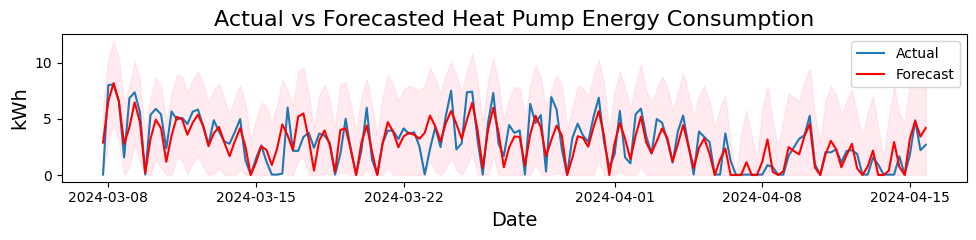

In [98]:
# Plot actual vs forecast
plt.figure(figsize=(10, 2.5))
plt.plot(test.index, test_data, label='Actual')
plt.plot(test.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("Actual vs Forecasted Heat Pump Energy Consumption", fontsize=16)
plt.xlabel("Date", fontsize=14) 
plt.ylabel("kWh", fontsize=14) 

plt.tight_layout()
plt.show()

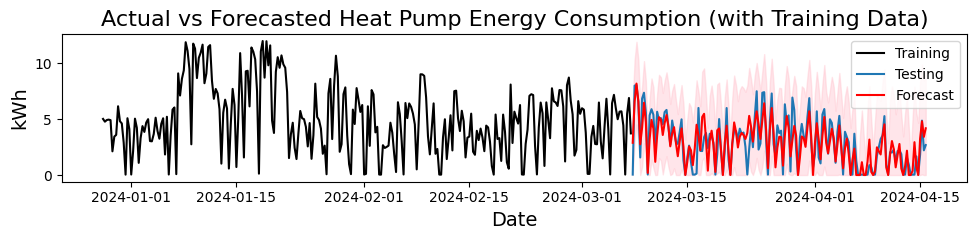

In [99]:
# plot with previous data

train_subset = train[-int(len(train) * 0.2):]

plt.figure(figsize=(10, 2.5))
plt.plot(train_subset.index, reverse_custom_root(train_subset['energy_consumption'], _BASE_), label='Training', color='black')
plt.plot(test.index, test_data, label='Testing')
plt.plot(test.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.4)
plt.legend()
plt.title("Actual vs Forecasted Heat Pump Energy Consumption (with Training Data)", fontsize=16)
plt.xlabel("Date", fontsize=14) 
plt.ylabel("kWh", fontsize=14)  

plt.tight_layout()
plt.show()

In [100]:
# evaluation metrics
mse = mean_squared_error(test_data, forecast_values)
mae = mean_absolute_error(test_data, forecast_values)
r2 = r2_score(test_data, forecast_values)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 1.5545858359771985
Mean Absolute Error: 0.9150628968629116
R² Score: 0.6737


(array([35.,  9., 11., 11., 13., 11., 11., 11., 10.,  7.,  3.,  1.,  3.,
         3.,  4.,  3.,  2.,  1.,  1.,  2.,  2.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  1.]),
 array([0.00510365, 0.15054336, 0.29598306, 0.44142277, 0.58686248,
        0.73230218, 0.87774189, 1.02318159, 1.1686213 , 1.31406101,
        1.45950071, 1.60494042, 1.75038012, 1.89581983, 2.04125953,
        2.18669924, 2.33213895, 2.47757865, 2.62301836, 2.76845806,
        2.91389777, 3.05933748, 3.20477718, 3.35021689, 3.49565659,
        3.6410963 , 3.78653601, 3.93197571, 4.07741542, 4.22285512,
        4.36829483]),
 <BarContainer object of 30 artists>)

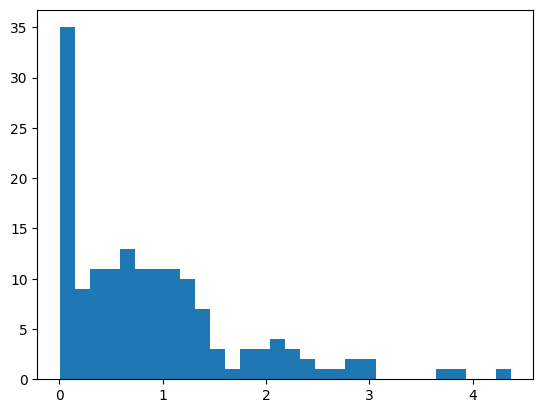

In [101]:
# histogram of absolute error
res = test_data - forecast_values
plt.hist(abs(res),bins = 30)